<a href="https://colab.research.google.com/github/KOdunga/AIMLCourse/blob/main/machinefailureprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# Library to split data
from sklearn.model_selection import train_test_split

# To build model for prediction
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay,
    make_scorer,
)

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [43]:
# prompt: load data set

df_main = pd.read_csv('/content/Predictive_Maintenance_Case_Study.csv')


In [44]:
# prompt: copy data set

data = df_main.copy()


In [45]:
data.head()

,UDI,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Failure
0,1,M,298.10000,323.74074,1551,42.80000,0,0
1,2,L,298.20000,324.11111,1408,46.30000,3,0
2,3,L,298.10000,323.37037,1498,49.40000,5,0
3,4,L,298.20000,323.74074,1433,39.50000,7,0
4,5,L,298.20000,324.11111,1408,40.00000,9,0


In [46]:
data.dtypes

UDI                      int64
Type                    object
Air temperature        float64
Process temperature    float64
Rotational speed         int64
Torque                 float64
Tool wear                int64
Failure                  int64
dtype: object

In [47]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.00000,5000.50000,2886.89568,1.00000,2500.75000,5000.50000,7500.25000,10000.00000
Air temperature,10000.00000,300.00493,2.00026,295.30000,298.30000,300.10000,301.50000,304.50000
Process temperature,10000.00000,328.94652,5.49531,313.00000,324.48148,329.29630,333.00000,343.00000
Rotational speed,10000.00000,1538.77610,179.28410,1168.00000,1423.00000,1503.00000,1612.00000,2886.00000
Torque,10000.00000,39.98691,9.96893,3.80000,33.20000,40.10000,46.80000,76.60000
Tool wear,10000.00000,107.95100,63.65415,0.00000,53.00000,108.00000,162.00000,253.00000
Failure,10000.00000,0.03390,0.18098,0.00000,0.00000,0.00000,0.00000,1.00000


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UDI                  10000 non-null  int64  
 1   Type                 10000 non-null  object 
 2   Air temperature      10000 non-null  float64
 3   Process temperature  10000 non-null  float64
 4   Rotational speed     10000 non-null  int64  
 5   Torque               10000 non-null  float64
 6   Tool wear            10000 non-null  int64  
 7   Failure              10000 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 625.1+ KB


In [49]:
data.shape

(10000, 8)

In [50]:
# prompt: check for missing values

data.isnull().sum()


UDI                    0
Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Failure                0
dtype: int64

In [51]:
# prompt: check for duplicate values

data.duplicated().sum()


0

In [52]:
# prompt: drop the column with unique values

data = data.drop(['UDI'],axis=1)


Exploratory Data Analysis

In [53]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [54]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [55]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [56]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

Univariate Data Analysis

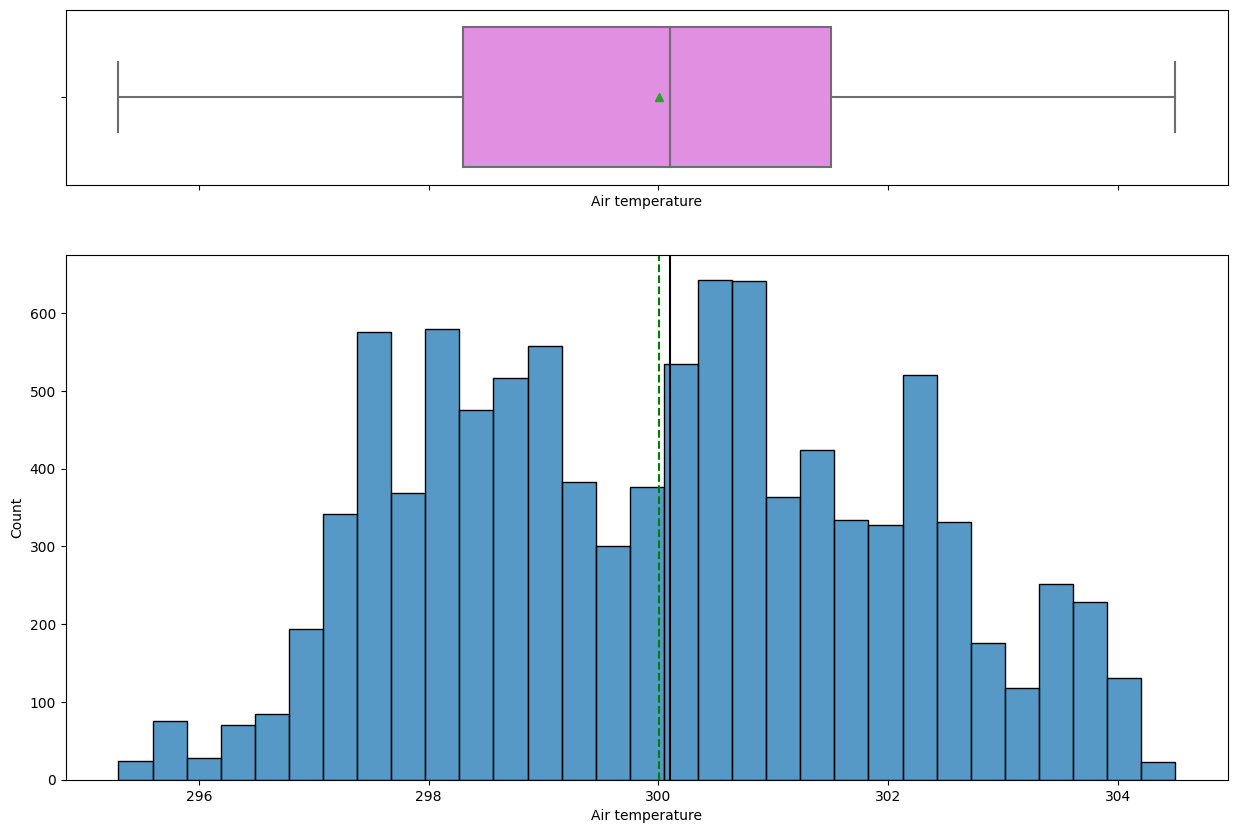

In [57]:
histogram_boxplot(data, "Air temperature")

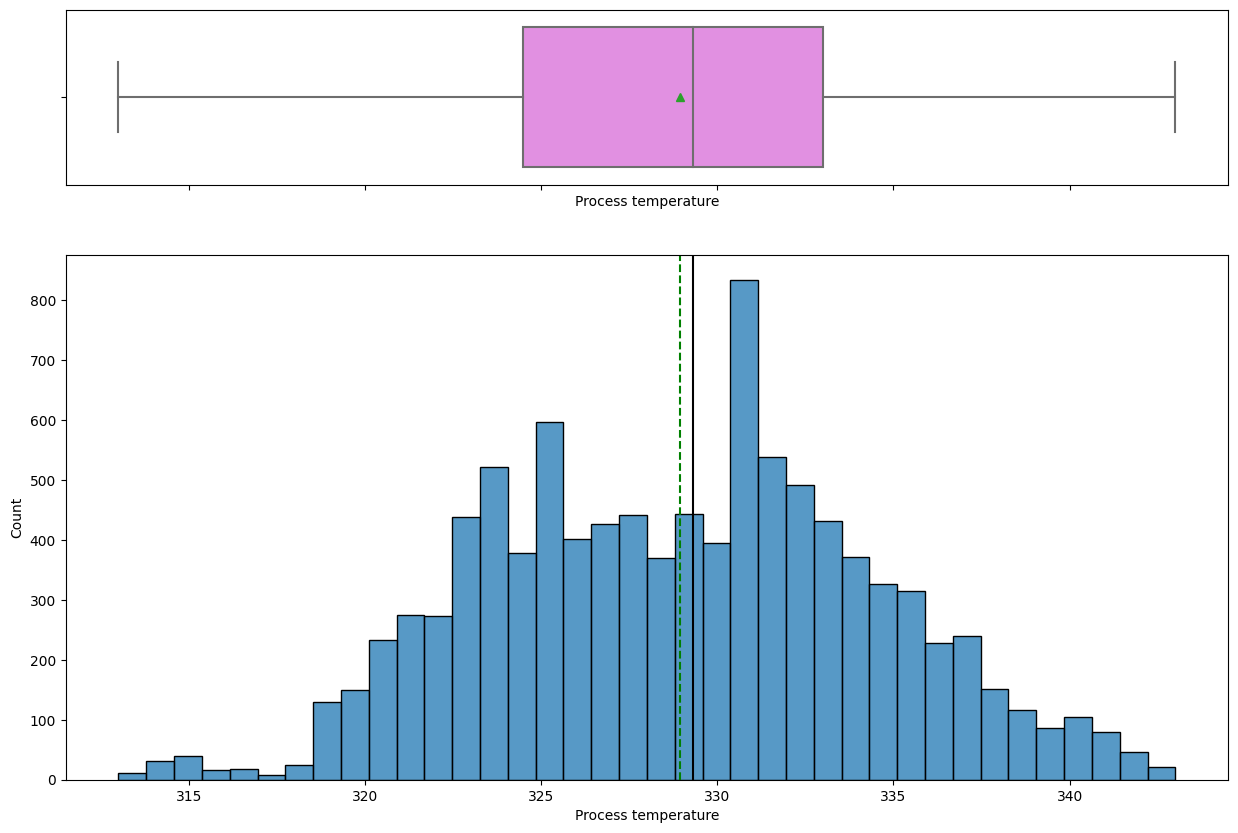

In [58]:
histogram_boxplot(data, "Process temperature")

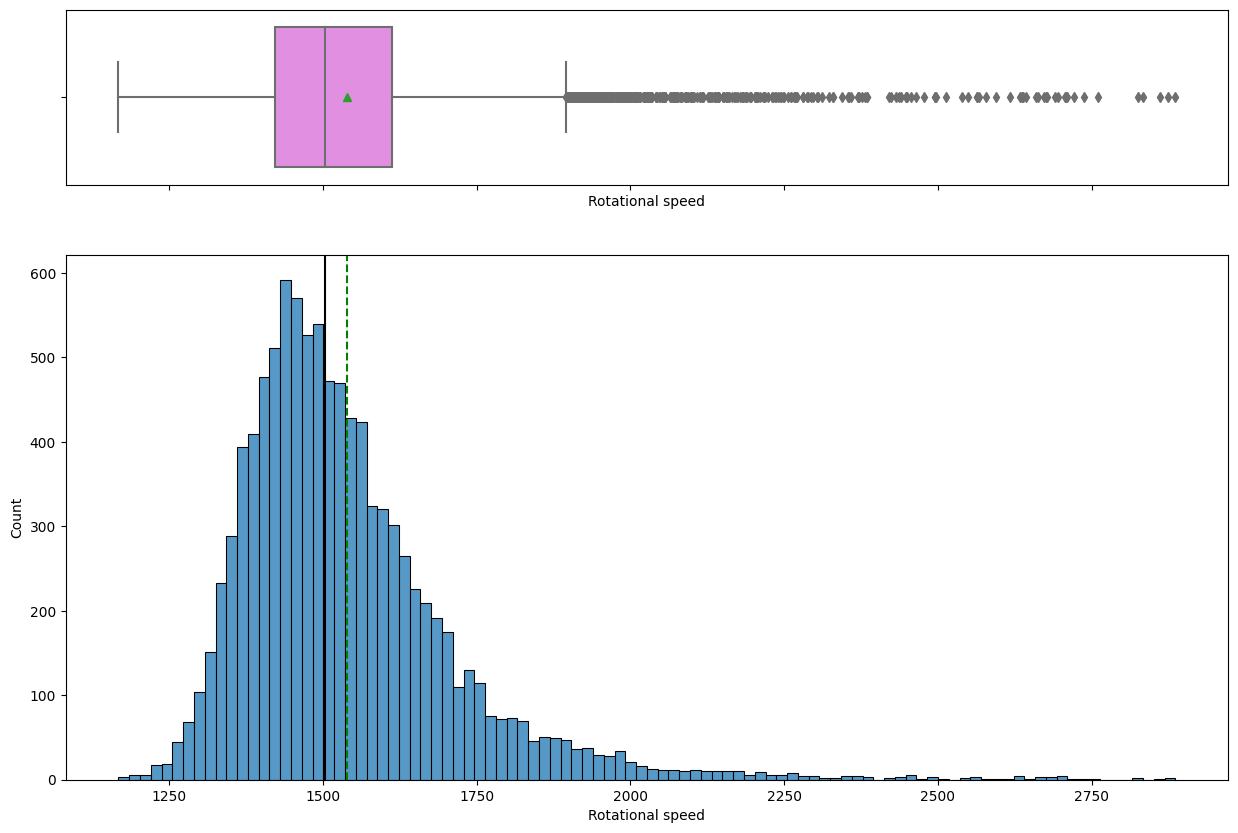

In [59]:
histogram_boxplot(data, "Rotational speed")

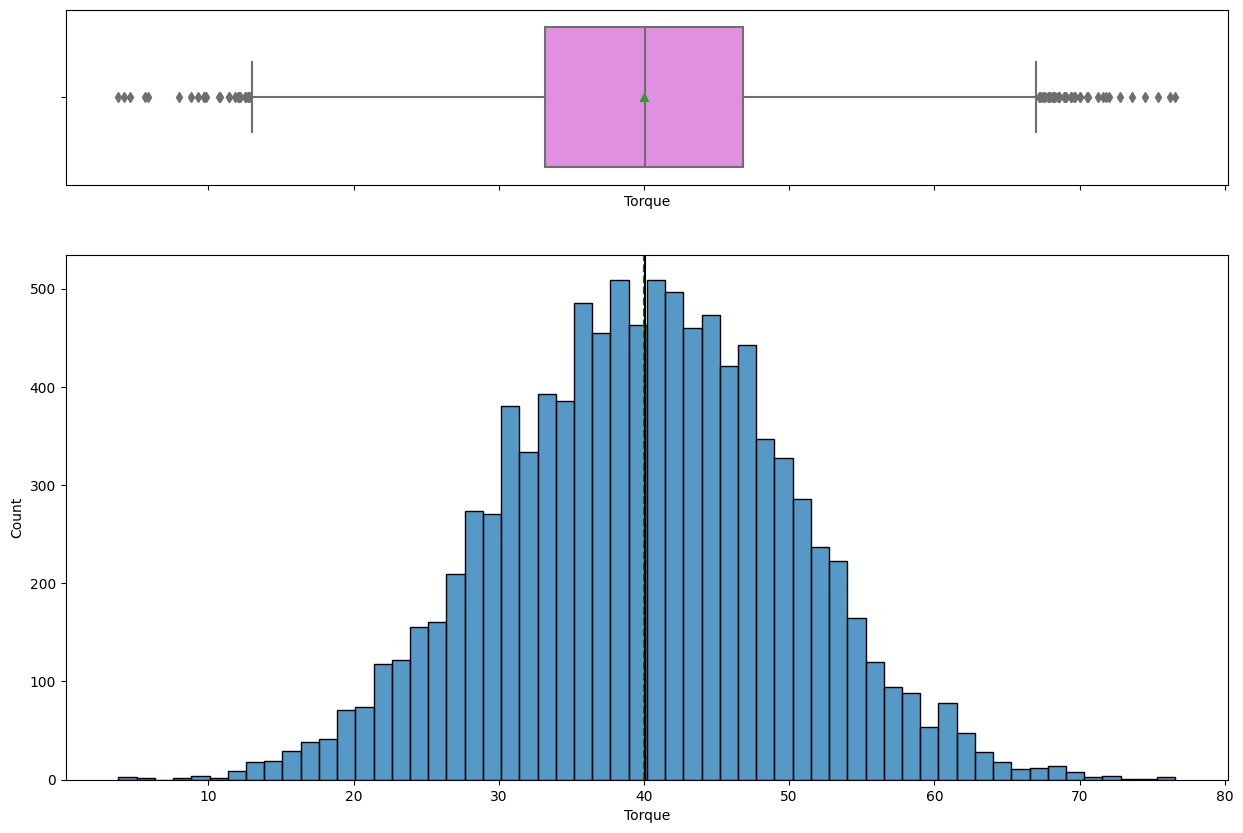

In [60]:
histogram_boxplot(data, "Torque")

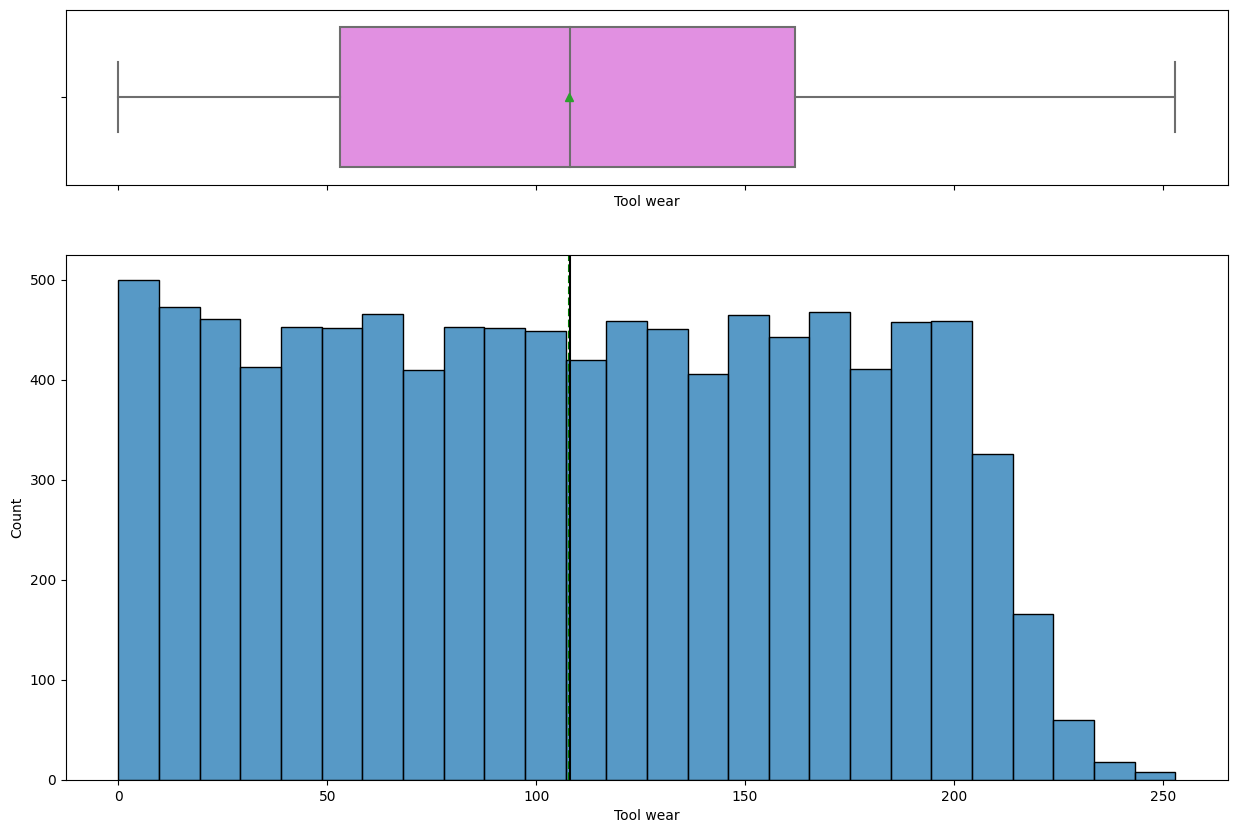

In [61]:
histogram_boxplot(data, "Tool wear")

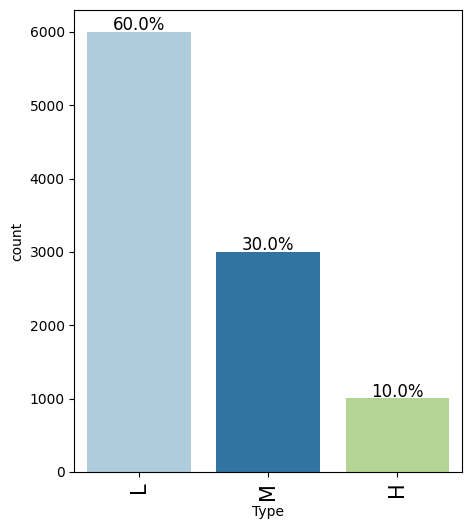

In [62]:
labeled_barplot(data, "Type", perc=True)

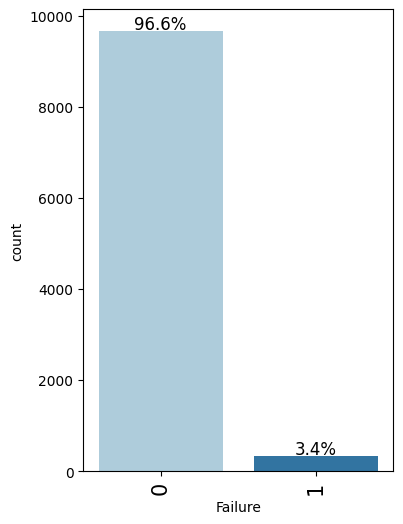

In [63]:
labeled_barplot(data, "Failure", perc=True)

Bivariate Analysis

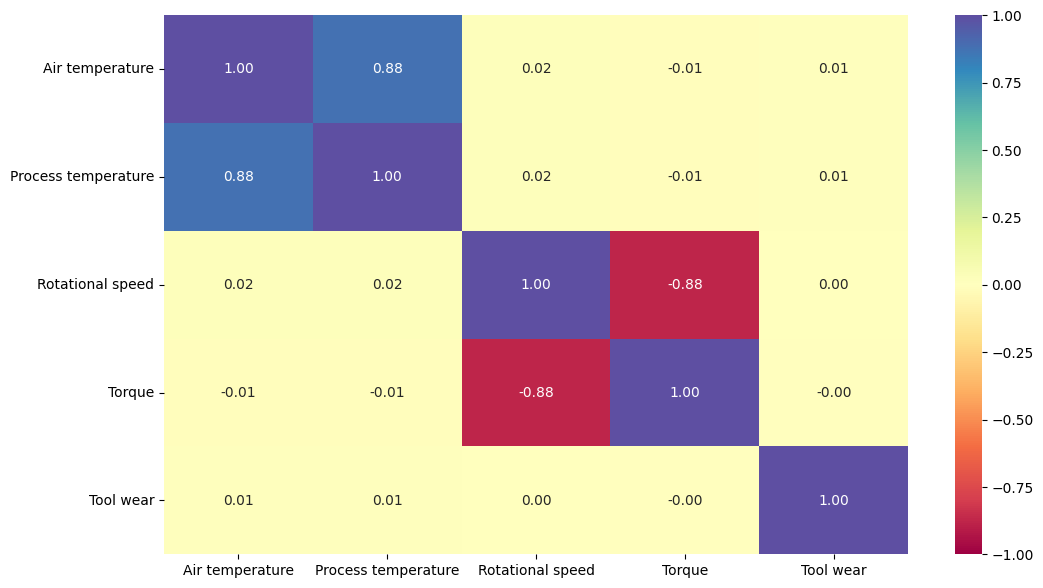

In [64]:
cols_list = data.select_dtypes(include=np.number).columns.tolist()
cols_list.remove('Failure')

plt.figure(figsize=(12, 7))
sns.heatmap(
    data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

Failure     0    1    All
Type                     
All      9661  339  10000
L        5765  235   6000
M        2914   83   2997
H         982   21   1003
------------------------------------------------------------------------------------------------------------------------


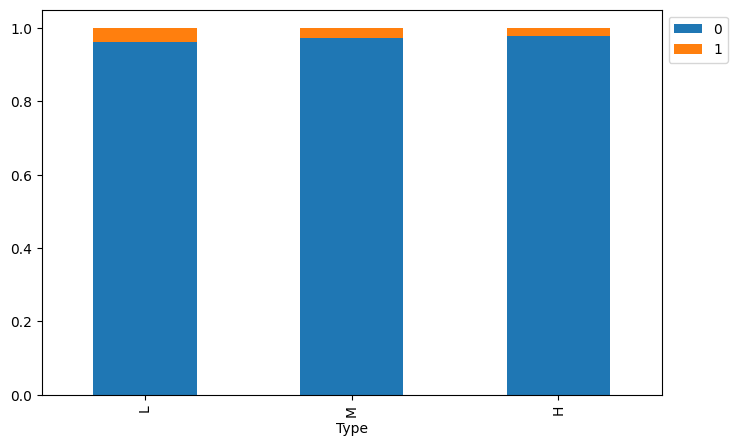

In [65]:
stacked_barplot(data, "Type", "Failure")

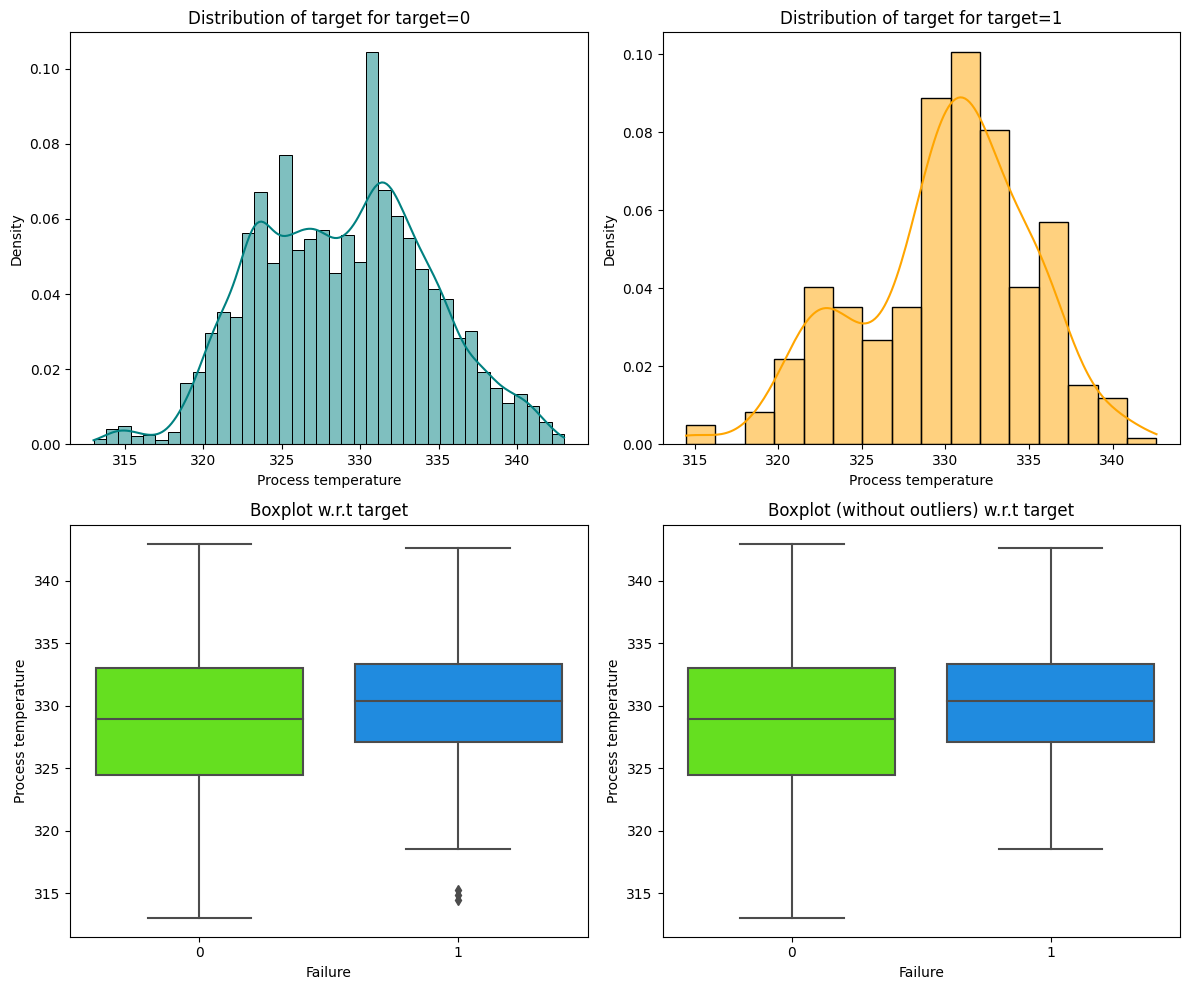

In [66]:
distribution_plot_wrt_target(data, "Process temperature", "Failure")

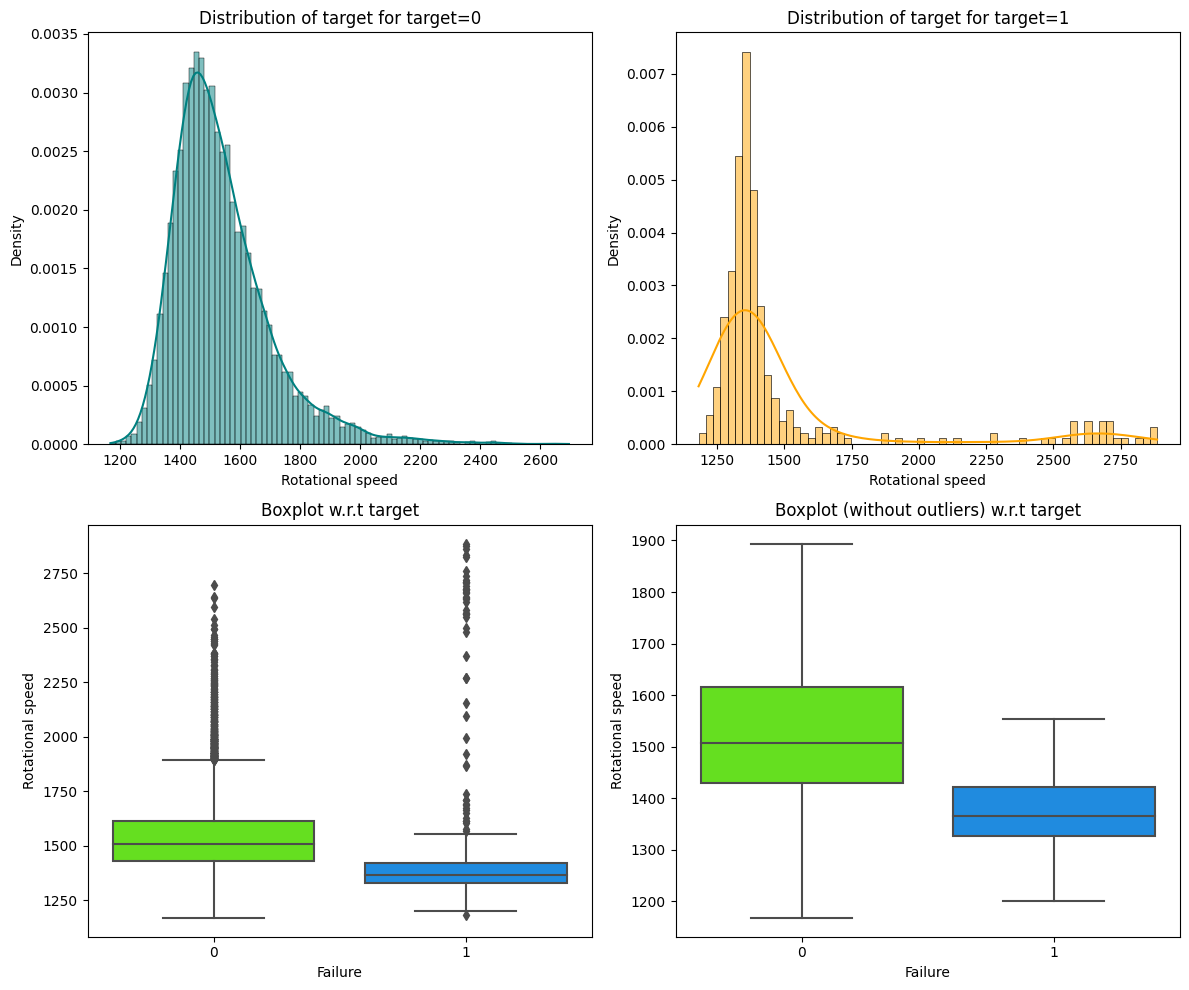

In [67]:
distribution_plot_wrt_target(data, "Rotational speed", "Failure")

## Data Pre Processing
- Check for Outliers

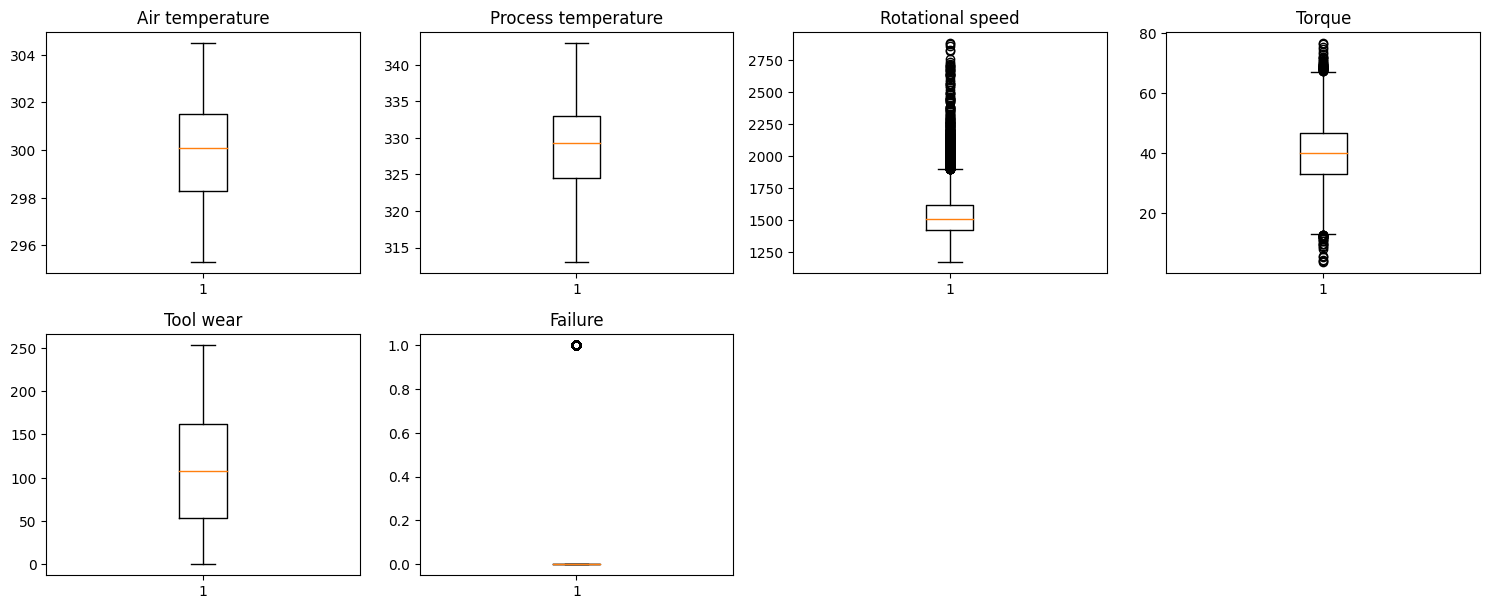

In [68]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [69]:
X = data.drop(["Failure"], axis=1)
Y = data["Failure"]

X = pd.get_dummies(X, drop_first=True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)


In [70]:
X.head()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Type_L,Type_M
0,298.10000,323.74074,1551,42.80000,0,0,1
1,298.20000,324.11111,1408,46.30000,3,1,0
2,298.10000,323.37037,1498,49.40000,5,1,0
3,298.20000,323.74074,1433,39.50000,7,1,0
4,298.20000,324.11111,1408,40.00000,9,1,0


In [71]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(round(y_train.value_counts(normalize=True)*100))
print("Percentage of classes in test set:")
print(round(y_test.value_counts(normalize=True)*100))

Shape of Training set :  (7000, 7)
Shape of test set :  (3000, 7)
Percentage of classes in training set:
0   97.00000
1    3.00000
Name: Failure, dtype: float64
Percentage of classes in test set:
0   97.00000
1    3.00000
Name: Failure, dtype: float64


## Model Building

In [73]:
model0 = DecisionTreeClassifier(random_state=1)
model0.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

## Model Evaluation

Minimize False Negatives, thus, maximize the Recall Score

In [77]:
from sklearn import metrics

In [78]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [79]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = metrics.confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

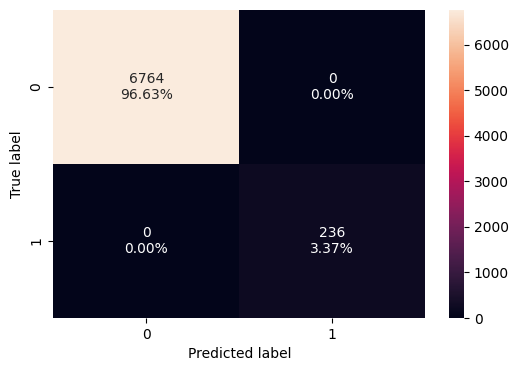

In [80]:
confusion_matrix_sklearn(model0, X_train, y_train)

In [81]:
decision_tree_perf_train_without = model_performance_classification_sklearn(
    model0, X_train, y_train
)
decision_tree_perf_train_without

,Accuracy,Recall,Precision,F1
0,1.00000,1.00000,1.00000,1.00000


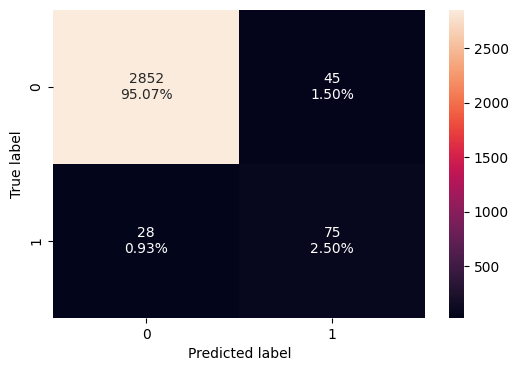

In [82]:
confusion_matrix_sklearn(model0, X_test, y_test)

In [83]:
decision_tree_perf_test_without = model_performance_classification_sklearn(
    model0, X_test, y_test
)
decision_tree_perf_test_without

,Accuracy,Recall,Precision,F1
0,0.97567,0.72816,0.62500,0.67265


Decision Tree (with class_weights)
- class_weight is a hyperparameter for the decision tree classifier
- we will set class_weight = "balanced", which will automatically adjust the weights to be inversely proportional to the class frequencies in the input data

In [84]:
model = DecisionTreeClassifier(random_state=1, class_weight="balanced")
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

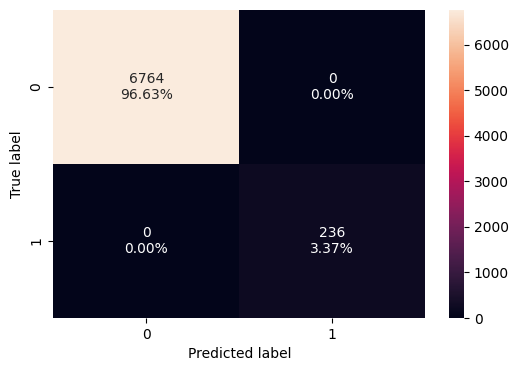

In [85]:
confusion_matrix_sklearn(model, X_train, y_train)

In [86]:
decision_tree_perf_train = model_performance_classification_sklearn(
    model, X_train, y_train
)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,1.00000,1.00000,1.00000,1.00000


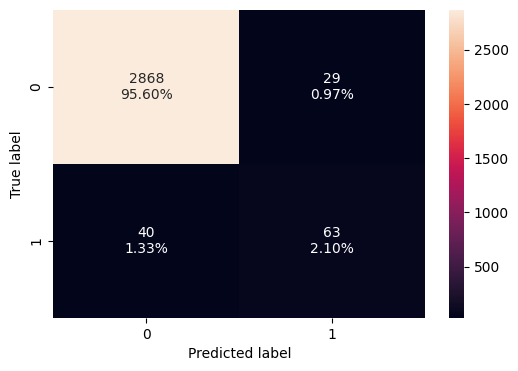

In [87]:
confusion_matrix_sklearn(model, X_test, y_test)

In [88]:
decision_tree_perf_test = model_performance_classification_sklearn(
    model, X_test, y_test
)
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.97700,0.61165,0.68478,0.64615


- There is a huge disparity in performance of model on training set and test set, which suggests that the model is overfiiting.

Decision Tree (Pre-pruning)
- use pruning techniques to try and reduce overfitting.

In [89]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "class_weight": [None, "balanced"],
    "max_depth": np.arange(2, 7, 2),
    "max_leaf_nodes": [50, 75, 150, 250],
    "min_samples_split": [10, 30, 50, 70],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=50,
                       min_samples_split=70, random_state=1)

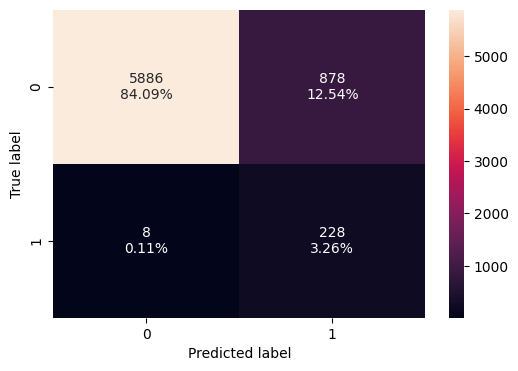

In [90]:
confusion_matrix_sklearn(estimator, X_train, y_train)

In [91]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(
    estimator, X_train, y_train
)
decision_tree_tune_perf_train

,Accuracy,Recall,Precision,F1
0,0.87343,0.96610,0.20615,0.33979


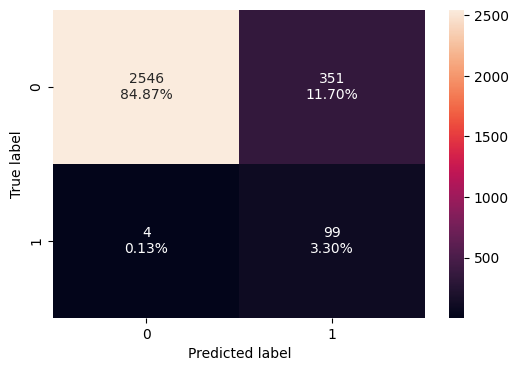

In [92]:
confusion_matrix_sklearn(estimator, X_test, y_test)

In [93]:
decision_tree_tune_perf_test = model_performance_classification_sklearn(
    estimator, X_test, y_test
)
decision_tree_tune_perf_test

,Accuracy,Recall,Precision,F1
0,0.88167,0.96117,0.22000,0.35805


- The model is giving a generalized result now since the recall scores on both the train and test data are coming to be around 0.96 which shows that the model is able to generalize well on unseen data.

In [94]:
feature_names = list(X_train.columns)
importances = estimator.feature_importances_
indices = np.argsort(importances)

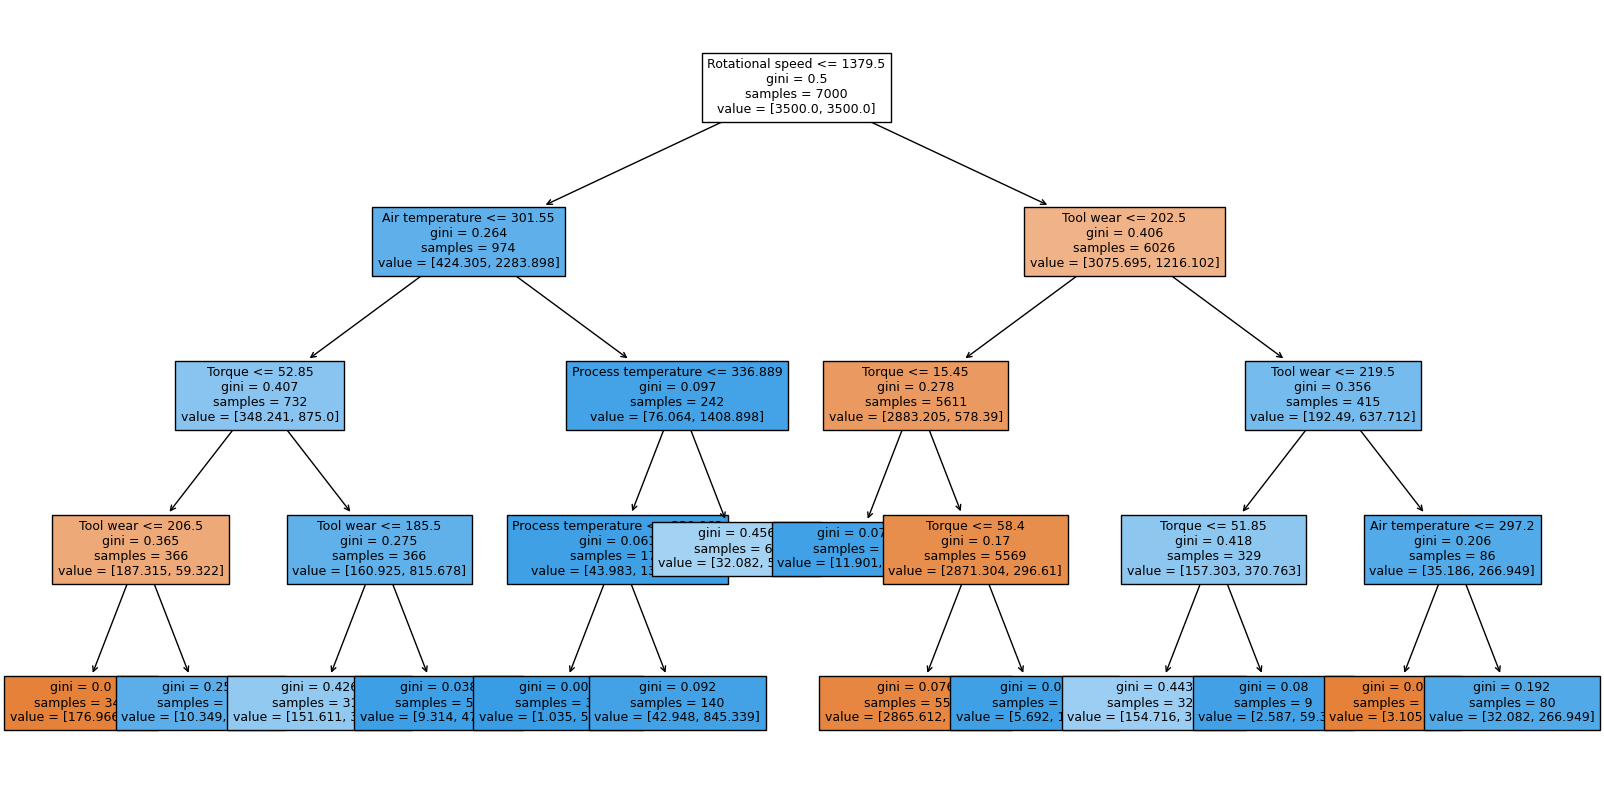

In [95]:
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [96]:
# Text report showing the rules of a decision tree -
print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

|--- Rotational speed <= 1379.50
|   |--- Air temperature <= 301.55
|   |   |--- Torque <= 52.85
|   |   |   |--- Tool wear <= 206.50
|   |   |   |   |--- weights: [176.97, 0.00] class: 0
|   |   |   |--- Tool wear >  206.50
|   |   |   |   |--- weights: [10.35, 59.32] class: 1
|   |   |--- Torque >  52.85
|   |   |   |--- Tool wear <= 185.50
|   |   |   |   |--- weights: [151.61, 341.10] class: 1
|   |   |   |--- Tool wear >  185.50
|   |   |   |   |--- weights: [9.31, 474.58] class: 1
|   |--- Air temperature >  301.55
|   |   |--- Process temperature <= 336.89
|   |   |   |--- Process temperature <= 330.96
|   |   |   |   |--- weights: [1.03, 504.24] class: 1
|   |   |   |--- Process temperature >  330.96
|   |   |   |   |--- weights: [42.95, 845.34] class: 1
|   |   |--- Process temperature >  336.89
|   |   |   |--- weights: [32.08, 59.32] class: 1
|--- Rotational speed >  1379.50
|   |--- Tool wear <= 202.50
|   |   |--- Torque <= 15.45
|   |   |   |--- weights: [11.90, 281.78] c

In [100]:
pd.DataFrame(estimator.feature_importances_, columns=['Imp'], index = X_train.columns).sort_values(by = 'Imp', ascending= False)

,Imp
Rotational speed,0.40081
Torque,0.32727
Tool wear,0.23463
Air temperature,0.03003
Process temperature,0.00727
Type_L,0.00000
Type_M,0.00000


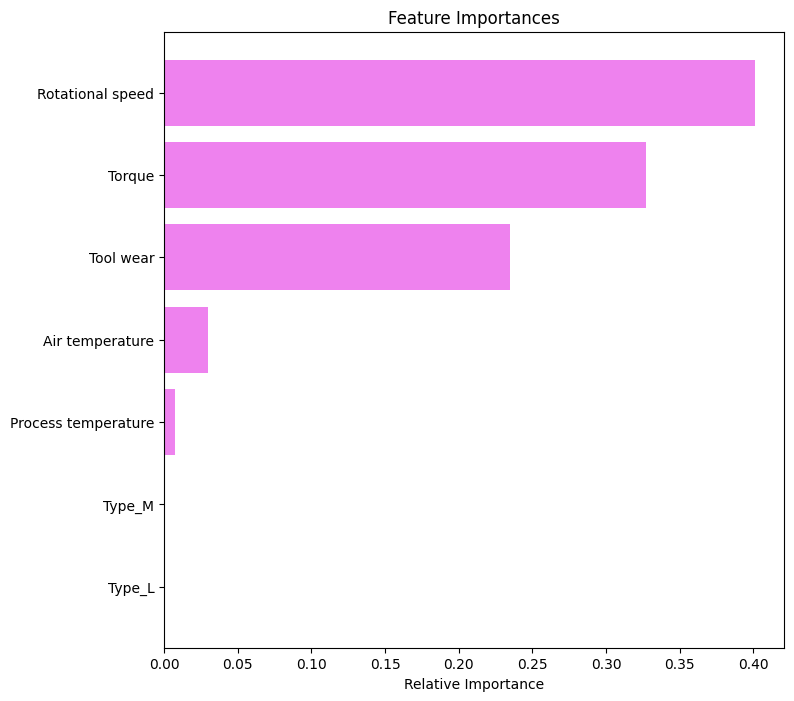

In [99]:
# importance of features in the tree building

importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Decision Tree (Post pruning)

In [101]:
clf = DecisionTreeClassifier(random_state=1, class_weight="balanced")
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities

In [102]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.00000,-0.00000
1,0.00000,-0.00000
2,0.00000,-0.00000
3,0.00000,-0.00000
4,0.00000,-0.00000
5,0.00000,-0.00000
6,0.00000,-0.00000
7,0.00000,-0.00000
8,0.00000,-0.00000
9,0.00000,-0.00000


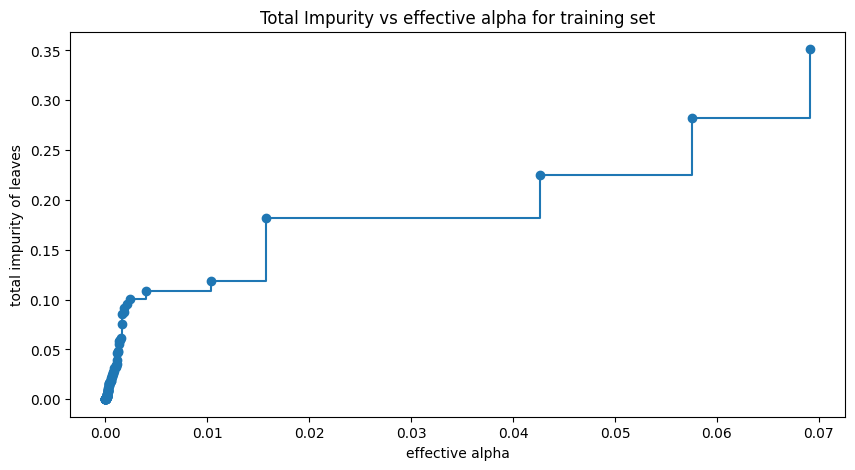

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [104]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=1, ccp_alpha=ccp_alpha, class_weight="balanced"
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.14875976077076158


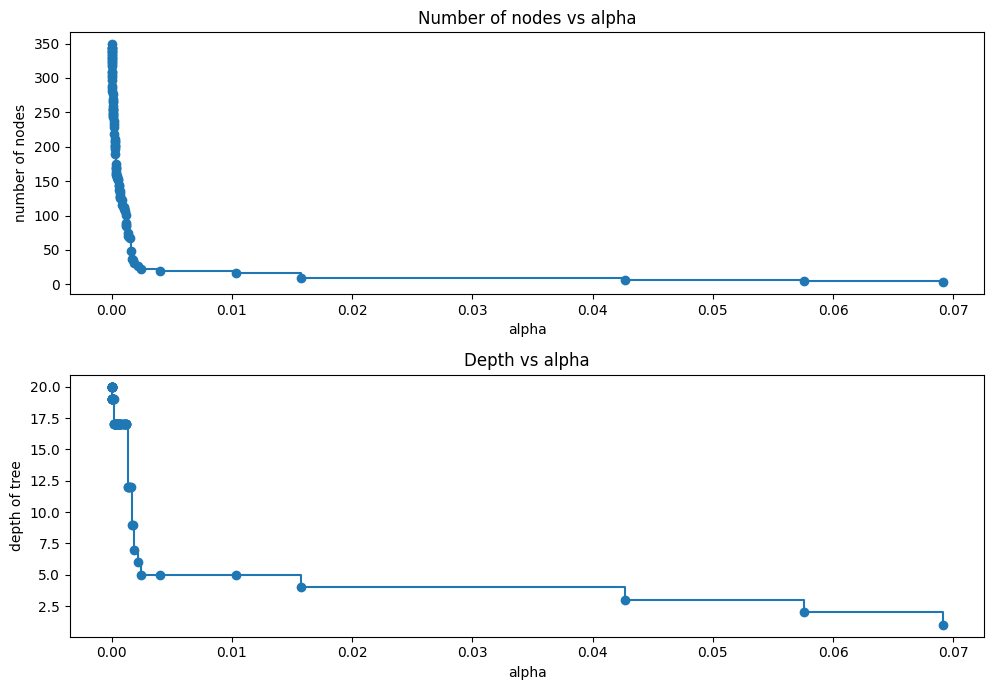

In [105]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [106]:
recall_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)

In [107]:
recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = recall_score(y_test, pred_test)
    recall_test.append(values_test)

In [108]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

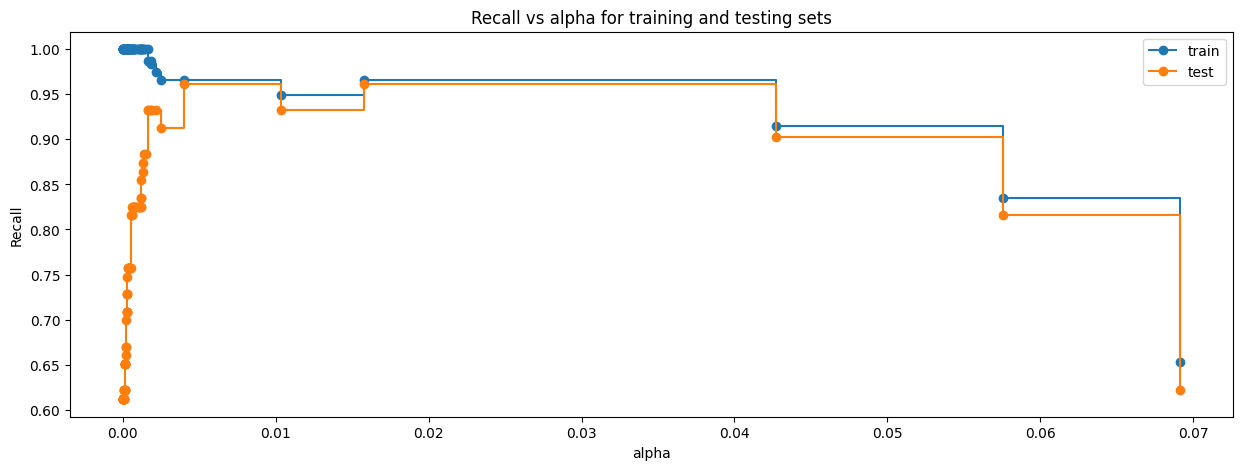

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(
    ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post",
)
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [110]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.004008680486241742, class_weight='balanced',
                       random_state=1)


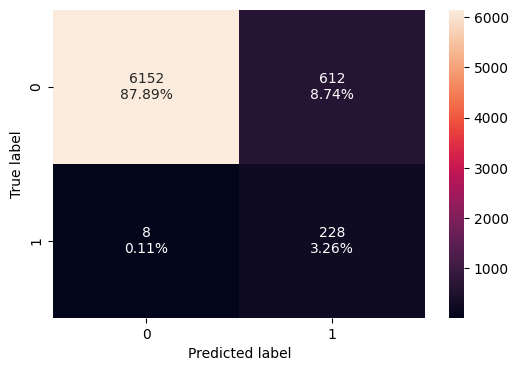

In [111]:
confusion_matrix_sklearn(best_model, X_train, y_train)

In [112]:
decision_tree_post_perf_train = model_performance_classification_sklearn(
    best_model, X_train, y_train
)
decision_tree_post_perf_train

,Accuracy,Recall,Precision,F1
0,0.91143,0.96610,0.27143,0.42379


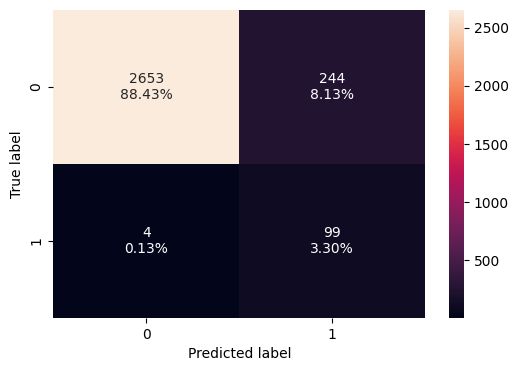

In [113]:
confusion_matrix_sklearn(best_model, X_test, y_test)

In [114]:
decision_tree_post_test = model_performance_classification_sklearn(
    best_model, X_test, y_test
)
decision_tree_post_test

,Accuracy,Recall,Precision,F1
0,0.91733,0.96117,0.28863,0.44395


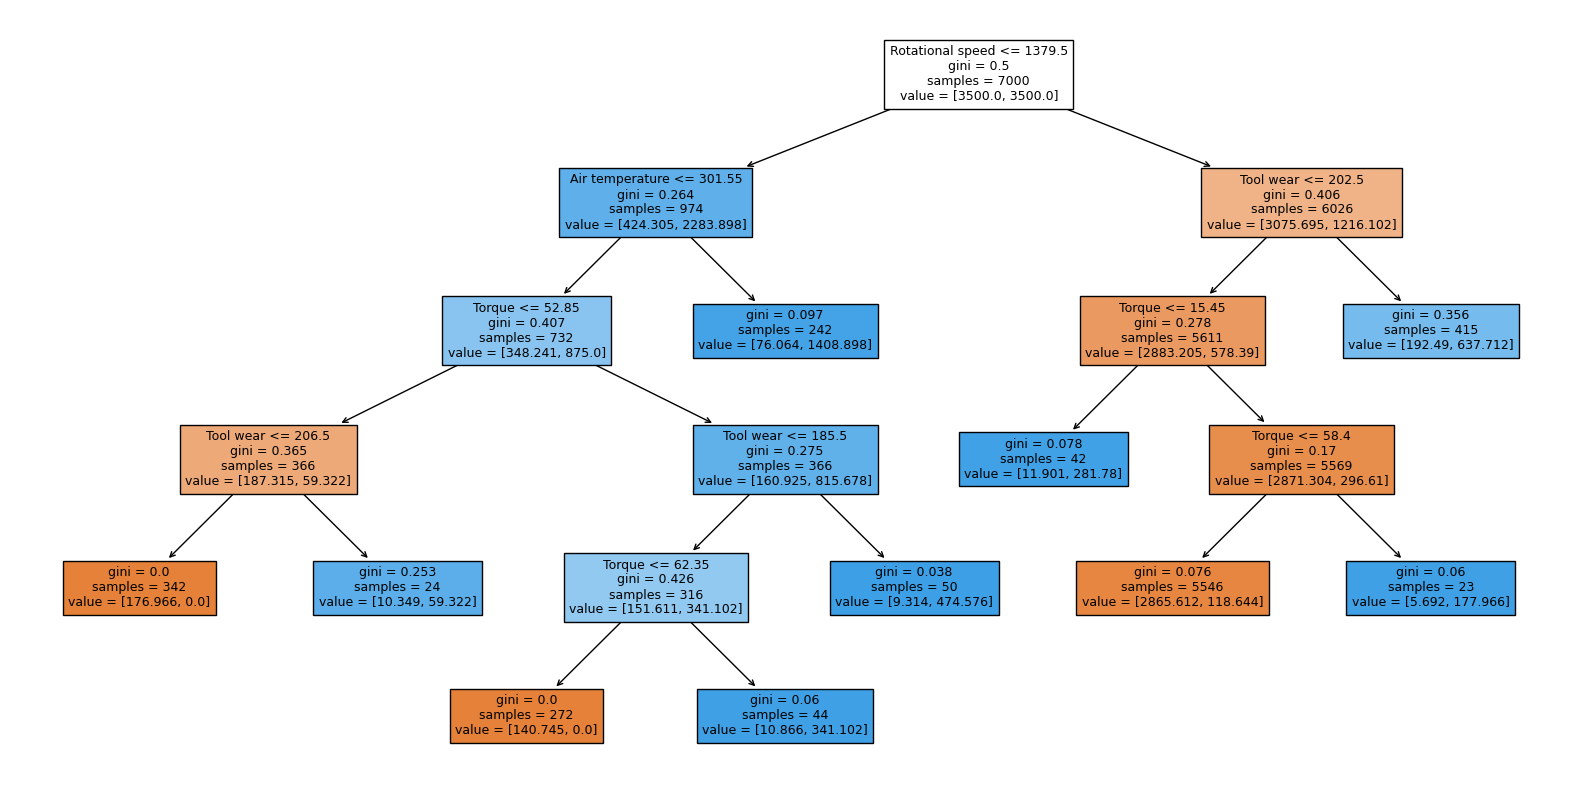

In [115]:
plt.figure(figsize=(20, 10))

out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [116]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model, feature_names=feature_names, show_weights=True))

|--- Rotational speed <= 1379.50
|   |--- Air temperature <= 301.55
|   |   |--- Torque <= 52.85
|   |   |   |--- Tool wear <= 206.50
|   |   |   |   |--- weights: [176.97, 0.00] class: 0
|   |   |   |--- Tool wear >  206.50
|   |   |   |   |--- weights: [10.35, 59.32] class: 1
|   |   |--- Torque >  52.85
|   |   |   |--- Tool wear <= 185.50
|   |   |   |   |--- Torque <= 62.35
|   |   |   |   |   |--- weights: [140.75, 0.00] class: 0
|   |   |   |   |--- Torque >  62.35
|   |   |   |   |   |--- weights: [10.87, 341.10] class: 1
|   |   |   |--- Tool wear >  185.50
|   |   |   |   |--- weights: [9.31, 474.58] class: 1
|   |--- Air temperature >  301.55
|   |   |--- weights: [76.06, 1408.90] class: 1
|--- Rotational speed >  1379.50
|   |--- Tool wear <= 202.50
|   |   |--- Torque <= 15.45
|   |   |   |--- weights: [11.90, 281.78] class: 1
|   |   |--- Torque >  15.45
|   |   |   |--- Torque <= 58.40
|   |   |   |   |--- weights: [2865.61, 118.64] class: 0
|   |   |   |--- Torque >  58

In [117]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

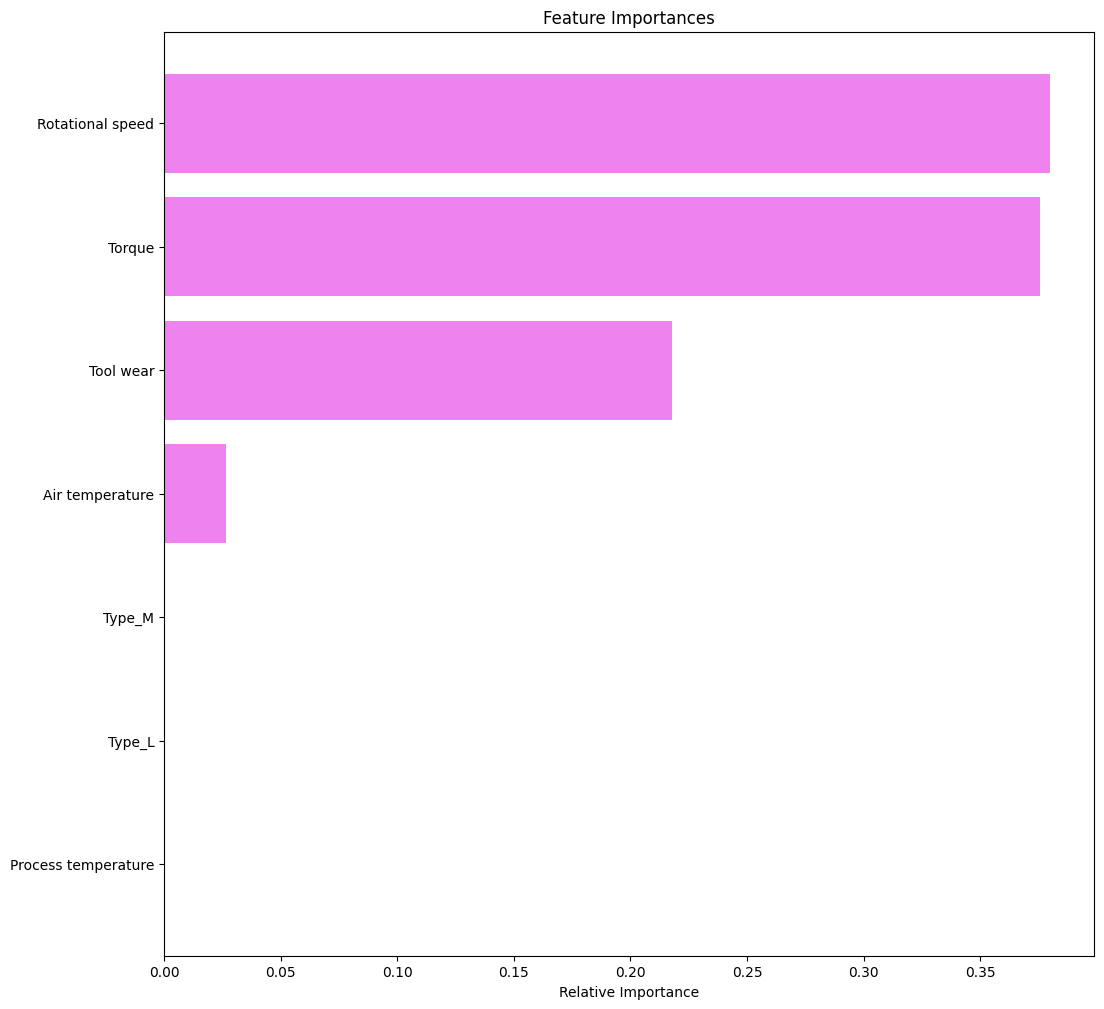

In [118]:
plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Comparison of Models and Final Model Selection

In [119]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train_without.T,
        decision_tree_perf_train.T,
        decision_tree_tune_perf_train.T,
        decision_tree_post_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree without class_weight",
    "Decision Tree with class_weight",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree without class_weight,Decision Tree with class_weight,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,1.00000,1.00000,0.87343,0.91143
Recall,1.00000,1.00000,0.96610,0.96610
Precision,1.00000,1.00000,0.20615,0.27143
F1,1.00000,1.00000,0.33979,0.42379


In [120]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        decision_tree_perf_test_without.T,
        decision_tree_perf_test.T,
        decision_tree_tune_perf_test.T,
        decision_tree_post_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree without class_weight",
    "Decision Tree with class_weight",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Decision Tree without class_weight,Decision Tree with class_weight,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.97567,0.97700,0.88167,0.91733
Recall,0.72816,0.61165,0.96117,0.96117
Precision,0.62500,0.68478,0.22000,0.28863
F1,0.67265,0.64615,0.35805,0.44395


- Decision tree models with pre-pruning and post-pruning both are giving equally high recall scores on both training and test sets.
- However, we will choose the post pruned tree as the best model since it is giving a slightly high precision score on the train and test sets than the pre-pruned tree.

## Conclusions and Recommendations
- The model built can be used to predict if a machine is going to fail or not and can correctly identify 96.1% of the machine failures

- Rotational speed, torque and tool wear are the most important variables in predicting whether a machine will fail or not

- From the decision tree, it has been observed that if the rotational speed is less than or equal to 1379.50, the air temperature is less than or equal to 301.55, the torque is less than or equal to 52.85 and the tool wear is greater than 206.50, then the machine is most likey to fail
- The company should give a vigilant eye for these values in order to detect machine failure.
- The company should use more data for the analysis to get more reliable results
As the variable used vary with the type of operation (turning, drilling, etc.) being performed, the company can look to build separate models for each different type of operation